# Imports

In [ ]:
# get tar.gz files
# !wget "https://courses.edx.org/assets/courseware/v1/ded9e59839c77f4037c800dcade5bd58/asset-v1:MITx+6.419x+3T2021+type@asset+block/release_gp_homework_data.tar.gz"
# !mv "release_gp_homework_data.tar.gz" "/content/drive/MyDrive/Colab Notebooks/MIT-DS/HW5"

In [ ]:
import tarfile
import numpy as np
import matplotlib.pyplot as plt

import itertools as it
from sklearn.model_selection import KFold
from scipy.stats import multivariate_normal as mv_normal

import jax.numpy as jnp

# Kernel, Regressor and Scores

In [ ]:
# Exponential Kernel
def RBF(sigma2=1.0, length=1.0):

  def call(x, y=None):
    if y is None: y = x
    return sigma2 * jnp.exp(-.5 * (x - y.T)**2 / length**2)
  
  return call

In [ ]:
# GaussianProcessRegressor
#
class GPRegressor:

  def __init__(self, kernel, tau):
    self.kernel = kernel
    self.tau = tau
  
  def get_cov(self, X, K_pred):
    K_fit = self.kernel(self.X)
    K_fit += self.tau * jnp.eye(self.X.shape[0])
    K_cov = self.kernel(X) 
    K_cov += self.tau * jnp.eye(X.shape[0])
    beta = jnp.linalg.solve(K_fit, K_pred)
    return K_cov - K_pred.T @ beta

  def fit(self, X, y):
    self.X, self.y = X, y
    K_fit = self.kernel(X)
    K_fit += self.tau * jnp.eye(X.shape[0])
    L_fit = jnp.linalg.cholesky(K_fit) 
    m_fit = jnp.linalg.solve(L_fit, y) 
    self.alpha = jnp.linalg.solve(L_fit.T, m_fit)
    return self

  def predict(self, X, return_cov=False):
    K_pred = self.kernel(self.X, X) 
    mu_pred = K_pred.T @ self.alpha
    if return_cov:
      cov = self.get_cov(X, K_pred)
      return mu_pred, cov
    return mu_pred

In [ ]:
# R2 
def r2_score(y_true, y_pred):
  true_mean = y_true.mean()
  model_err = jnp.square(y_true - y_pred).sum()
  mean_dev = jnp.square(y_true - true_mean).sum()
  return 1.0 - model_err/mean_dev

# log-likelihood 
def ll_score(y_true, y_pred, cov_pred, allow_singular=False):
  return mv_normal.logpdf(
      y_true, mean=y_pred, cov=cov_pred, 
      allow_singular=allow_singular)

# Load Data, perform CV Grid Search

In [ ]:
# load data tensor from each U,V file
dirname = "/content/drive/MyDrive/Colab Notebooks/MIT-DS/HW5/"
filename = dirname + "release_gp_homework_data.tar.gz"
with tarfile.open(filename, "r:gz") as tf:
  data = jnp.array([np.array([
          np.loadtxt(tf.extractfile(f"OceanFlow/{i}{w}.csv"), delimiter=',')
          for w in "uv"]).T for i in range(1, 101)])
data.shape

(100, 555, 504, 2)

In [ ]:
# coords to test
coords = [(100, 350), (495, 410), (120, 440), (480, 120), (150, 210)]

# U/V vectors
velocity_vectors = [data[:, x, y, uv] \
  for (x, y), uv in it.product(coords, (0, 1))]

# X's for train & predict
X_100 = jnp.array(range(0, 300, 3))[:,jnp.newaxis]
X_300 = jnp.array(range(0, 300, 1))[:,jnp.newaxis]

In [ ]:
# Perform Grid Search with Cross Validation over each point
#
tau = 0.00001 # 0.001, 0.0001
sigma2_range = np.arange(0.0, 3.5, 0.5)
length_range = np.arange(1.0, 9.5, 1.0) 

all_scores = []
all_values = []

for i, y in enumerate(velocity_vectors):

  cv_scores = []
  cv_values = []

  for sigma2, length in it.product(sigma2_range, length_range):

    sigma2 = max(round(sigma2, 1), 0.1)
    length = max(round(length, 1), 0.1)

    kernel = RBF(sigma2, length)
    model = GPRegressor(kernel=kernel, tau=tau)

    ll_scores, r2_scores = [], []
    cv = KFold(n_splits=10, shuffle=True, random_state=0)

    for train_index, test_index in cv.split(X_100, y):

      model.fit(X_100[train_index], y[train_index])      
      y_pred, cov = model.predict(X_100[test_index], 
                                  return_cov=True)
      
      ll_scores.append(ll_score(y[test_index], y_pred, cov))
      r2_scores.append(r2_score(y[test_index], y_pred))

    cv_scores.append(np.mean(ll_scores))
    cv_values.append((sigma2, length, 
                      np.mean(r2_scores)))

  all_scores.append(cv_scores)
  all_values.append(cv_values)

  print(f"Best CV score for {i}: {np.max(cv_scores)}")
  print("Values: ", cv_values[np.argmax(cv_scores)])

Best CV score for 0: 19.664729272628005
Values:  (0.1, 4.0, 0.9507063)
Best CV score for 1: 20.169026504730073
Values:  (0.1, 4.0, 0.9800025)
Best CV score for 2: 27.819468536423148
Values:  (0.5, 6.0, 0.97062254)
Best CV score for 3: 18.996829098419358
Values:  (0.1, 4.0, 0.96413213)
Best CV score for 4: 20.686254811117966
Values:  (0.1, 4.0, 0.98028815)
Best CV score for 5: 19.6867701897286
Values:  (0.1, 4.0, 0.98766744)
Best CV score for 6: 20.467725810096425
Values:  (0.1, 4.0, 0.62573063)
Best CV score for 7: 23.458678248488535
Values:  (3.0, 9.0, 0.9661401)
Best CV score for 8: 12.745089921891982
Values:  (0.1, 4.0, 0.73935837)
Best CV score for 9: 12.596799228593511
Values:  (0.1, 4.0, 0.49085015)


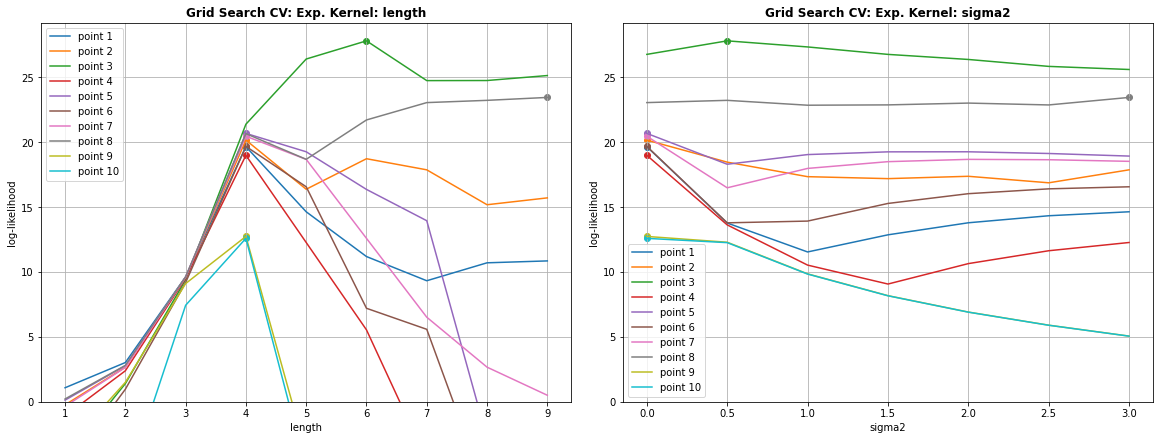

In [ ]:
# plot separate scores for each param 
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(16, 6), 
                       constrained_layout=True)

for k, r, l in [(1, sigma2_range, "sigma2"), (0, length_range, "length")]:

  axs[k].set_title(f"Grid Search CV: Exp. Kernel: {l}", fontweight="bold")
  d1, d2 = len(sigma2_range), len(length_range)
  axs[k].set_ylim((0, np.max(all_scores)*1.05))

  for i, scores in enumerate(all_scores):
    values = np.max(np.reshape(scores, (d1, d2)), axis=k)
    axs[k].plot(r, values, label=f"point {i+1}")
    axs[k].scatter(r[jnp.argmax(values)], np.max(values))

  axs[k].set_xlabel(l)
  axs[k].set_ylabel("log-likelihood")
  axs[k].grid(True)
  axs[k].legend()

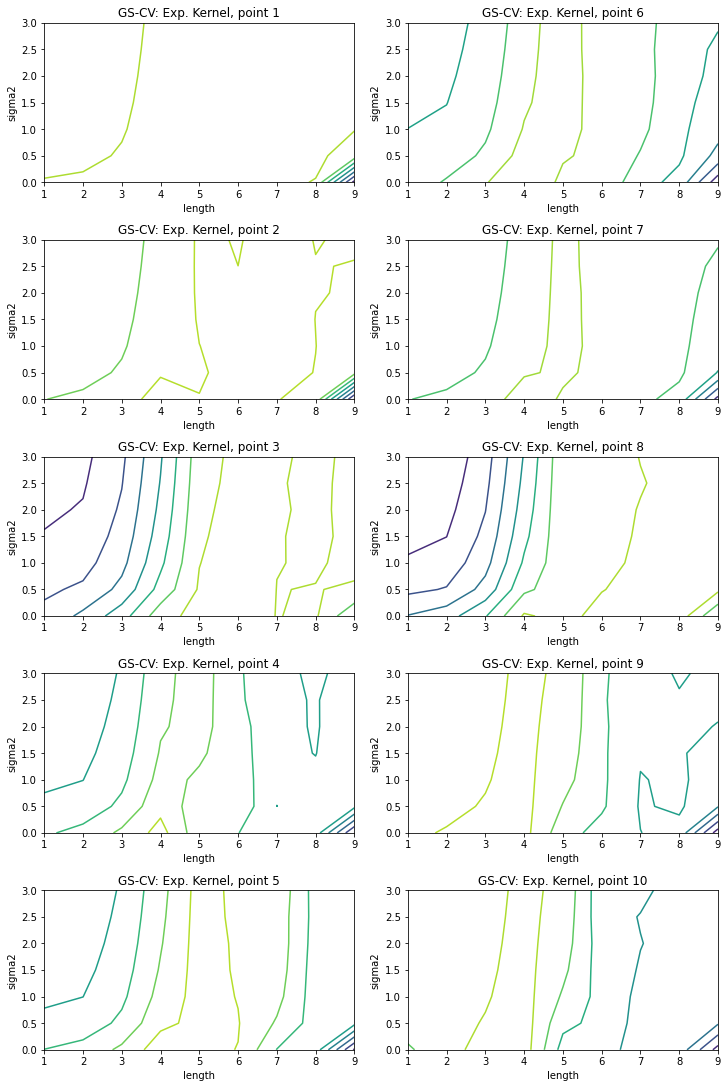

In [ ]:
# now a contour plot for each test point
fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(10, 15), 
                       constrained_layout=True)
d1, d2 = len(sigma2_range), len(length_range)

for k, scores in enumerate(all_scores):

  i, j = int(k%5), k//5
  z_val = np.reshape(scores, (d1, d2))
  axs[i, j].contour(length_range, sigma2_range, z_val)

  axs[i, j].set_title(f"GS-CV: Exp. Kernel, point {k+1}")
  axs[i, j].set_xlabel("length")
  axs[i, j].set_ylabel("sigma2")

plt.show()

In [ ]:
# this one is pretty ;-) 
def plot_model(X_train, y_train, X_pred, y_pred, sigma=None):
  
  plt.figure(figsize=(16,9))

  plt.plot(X_train, y_train, "r.", markersize=10, label="Observations")

  plt.plot(X_pred, y_pred, "b-", label="Predictions")

  if sigma is not None:
    plt.fill_between(X_pred[:,0], y_pred - 3*sigma, y_pred + 3*sigma,
                    alpha=0.2, fc="g", label="3 Sigma band")
  
  plt.legend()
  plt.xlabel("days")
  plt.ylabel("velocity component")
  plt.title("Ocean Flow", fontweight="bold")
  plt.grid(True)
  plt.show()


Score 0: 0.9999954700469971


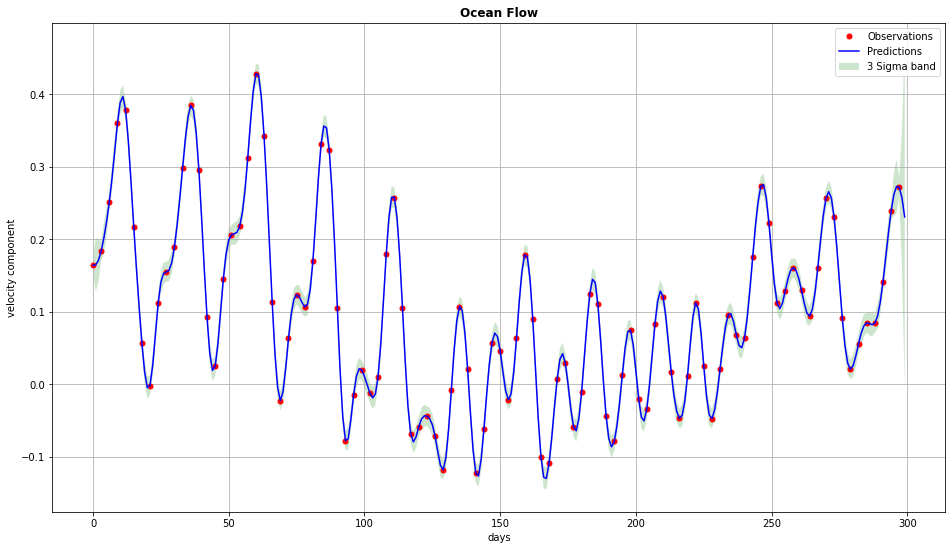


Score 1: 0.9999983310699463


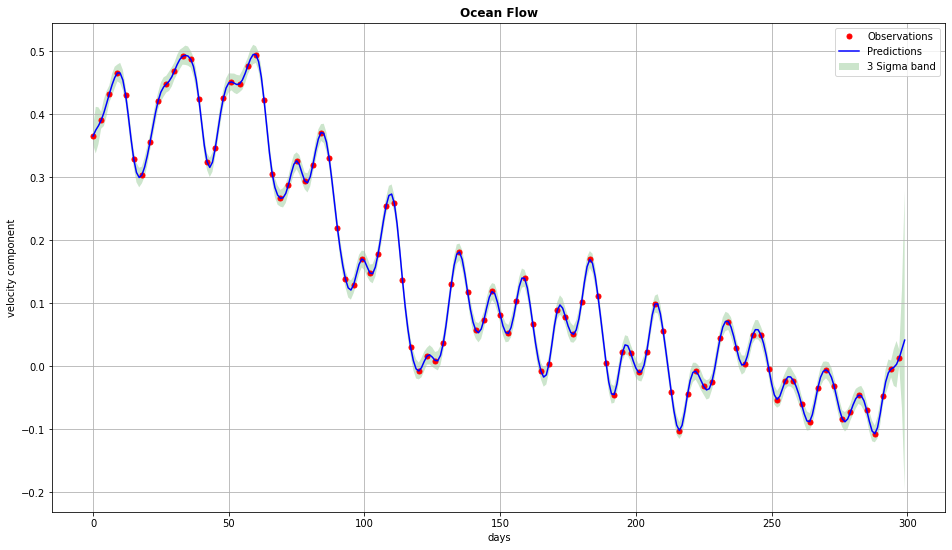


Score 2: 0.9999992251396179


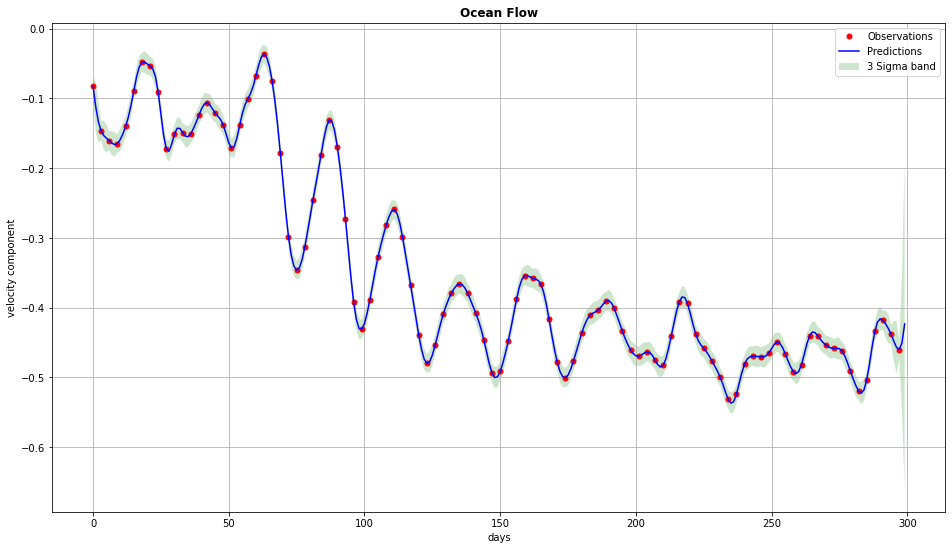


Score 3: 0.9999973773956299


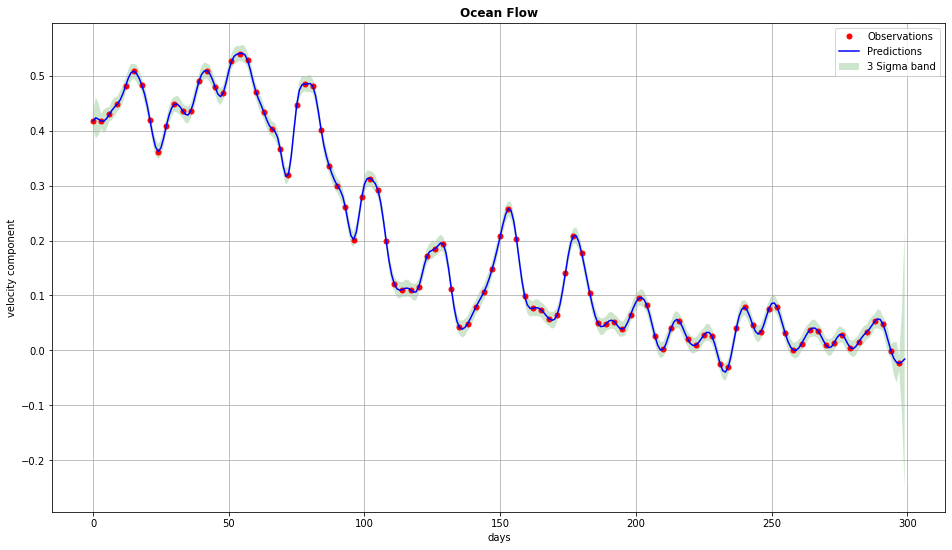


Score 4: 0.999998927116394


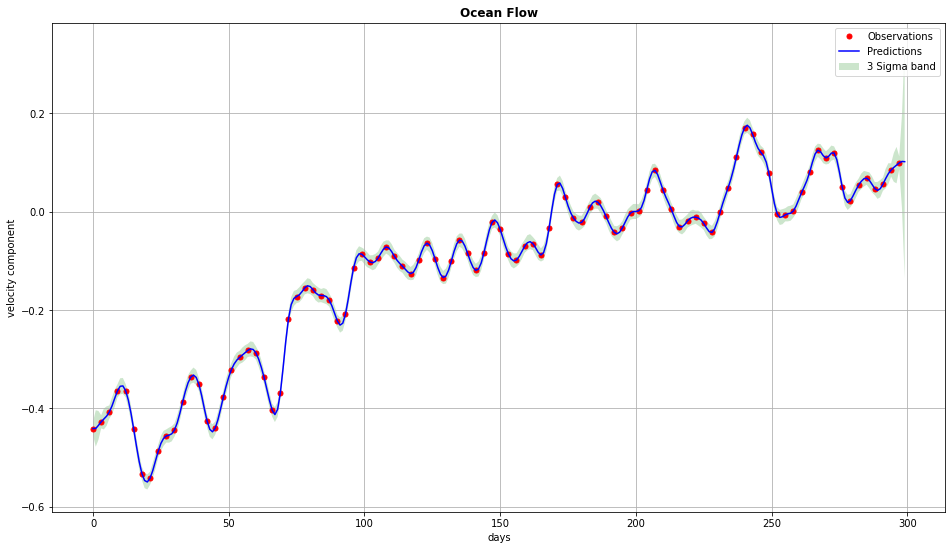


Score 5: 0.999999463558197


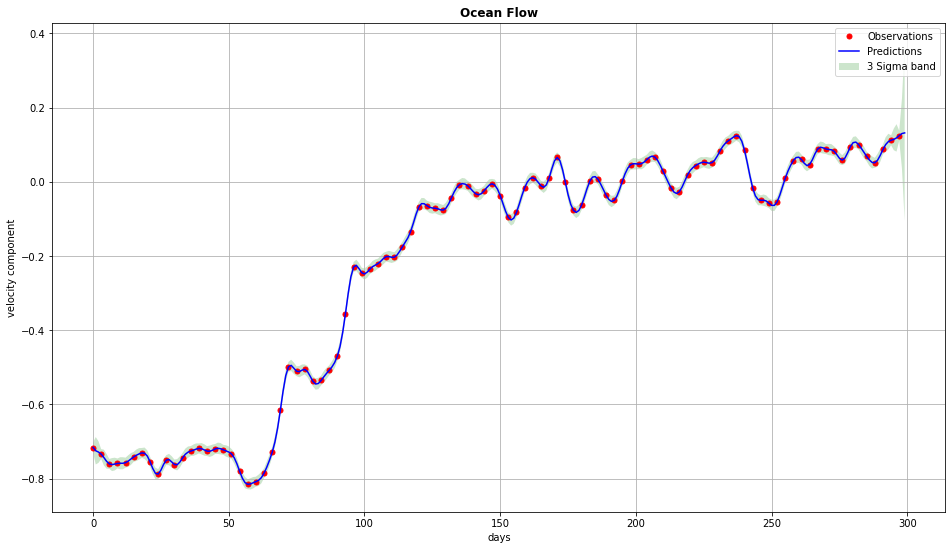


Score 6: 0.9999942779541016


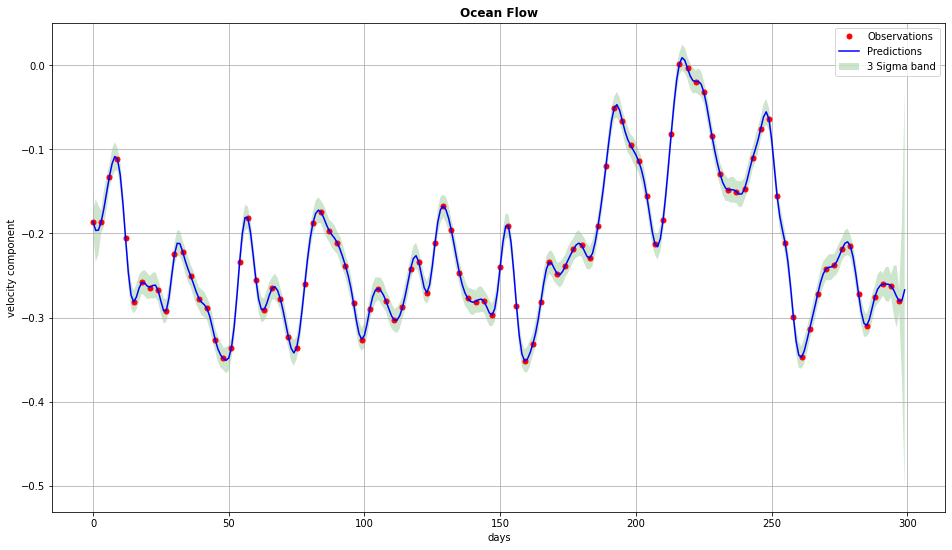


Score 7: 0.9999944567680359


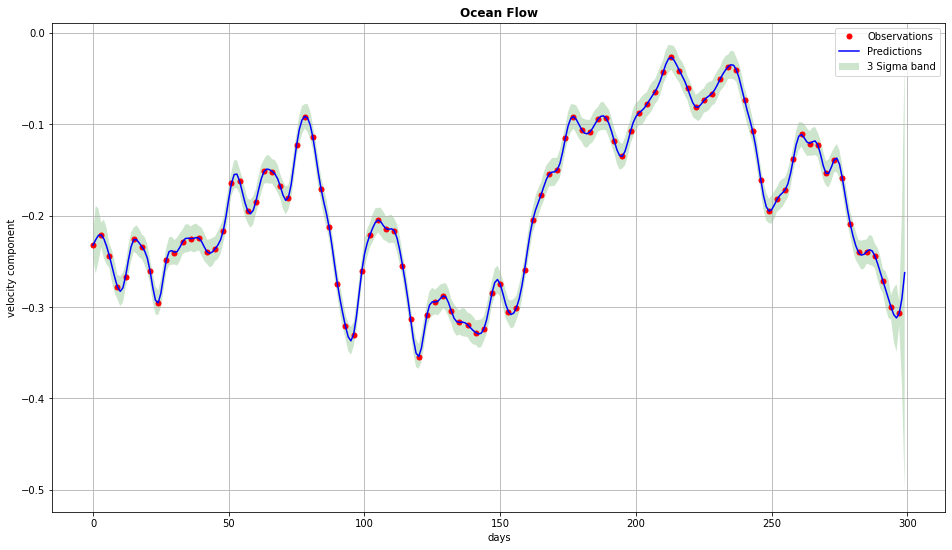


Score 8: 0.9999872446060181


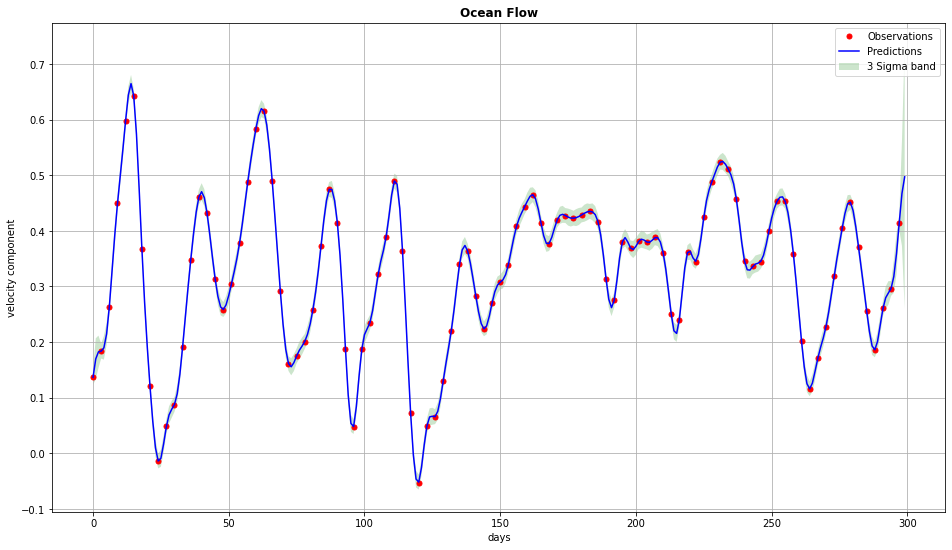


Score 9: 0.9999986886978149


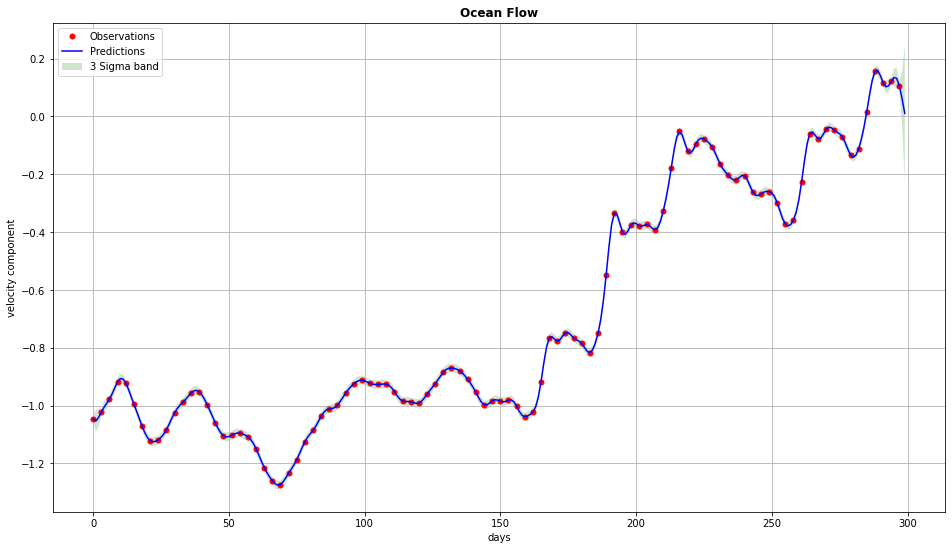


Average R2: 0.99999636


In [ ]:
# plot data, predictions & sigma bands
#
score_sum = 0.0
for i, y in enumerate(velocity_vectors):
  
  kernel = RBF(sigma2=0.1, length=4.0)
  model = GPRegressor(kernel=kernel, tau=0.00001)

  model.fit(X_100, y)

  # we can only score R2 for known data (ie X_100, y)
  score = r2_score(y, model.predict(X_100))
  score_sum += score
  print(f"\nScore {i}: {score}") 

  # predict over new unseen data: X_300 
  y_pred, cov = model.predict(X_300, return_cov=True)
  sigma = jnp.sqrt(jnp.diagonal(cov))
  plot_model(X_100, y, X_300, y_pred, sigma)
  #break

print("\nAverage R2:", score_sum/len(velocity_vectors))

# Fast-Predict ALL DATA & Save UV

In [ ]:
# X's for train & predict
X_100 = jnp.array(range(0, 300, 3))[:,jnp.newaxis]
X_300 = jnp.array(range(0, 300, 1))[:,jnp.newaxis]

# best model, predict utility
model = GPRegressor(kernel=RBF(sigma2=0.1, length=4.0), tau=0.00001)
predict = lambda y: jnp.where(y.any(), 
                              model.fit(X_100, y).predict(X_300),
                              jnp.zeros(300))

# vectorize prediction function
v_predict = jnp.vectorize(predict, signature='(100)->(300)')

In [ ]:
s = 5 # quick sanity check
for x, y in [(0, 0)] + coords:
  
  u1 = v_predict(data[:,x:x+s,y:y+s,0].T).T

  u2 = np.empty((300, s, s))
  for i in range(s):
    for j in range(s):
      u2[:,i,j] = predict(data[:,x+i,y+j,0])

  print("Testing: ", x, y)
  print("Sum:", int(u1.sum()), int(u2.sum()))
  print()

  assert u1.shape == u2.shape
  np.testing.assert_array_almost_equal(u1, u2, decimal=5)

Testing:  0 0
Sum: -649 -649

Testing:  100 350
Sum: 630 630

Testing:  495 410
Sum: -2083 -2083

Testing:  120 440
Sum: -1053 -1053

Testing:  480 120
Sum: -2318 -2318

Testing:  150 210
Sum: 2101 2101



In [ ]:
# fit & predict ALL U's & U's
#
# Running times in my Colab instance
# < 30ms GPU and < 7s CPU
#
all_us = v_predict(data[:,:,:,0].T).T
all_vs = v_predict(data[:,:,:,1].T).T

all_us.shape, all_vs.shape

((300, 555, 504), (300, 555, 504))

In [ ]:
# save our predictions (uncomment)
#
# np.save(dirname + "U.npy", all_us)
# np.save(dirname + "V.npy", all_vs)


Point: (100, 350) - U component


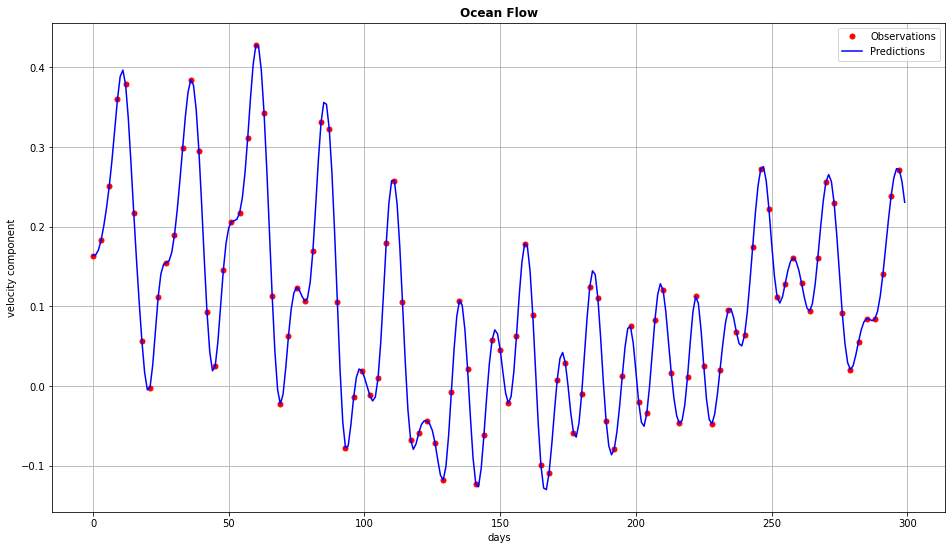


Point: (100, 350) - V component


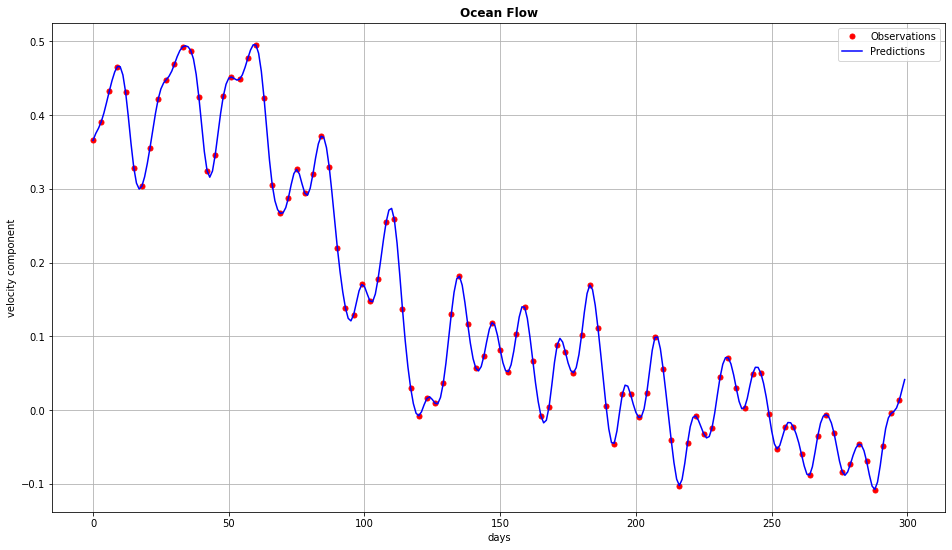


Point: (495, 410) - U component


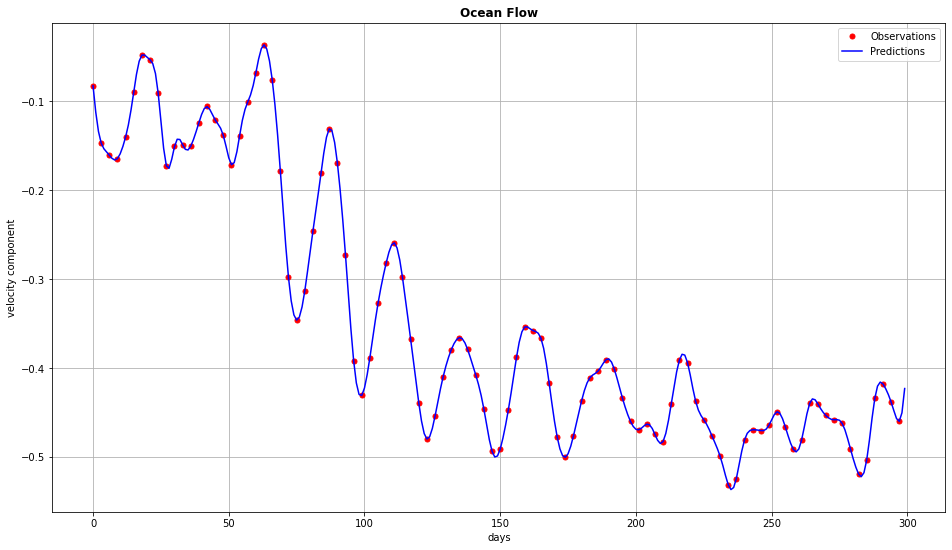


Point: (495, 410) - V component


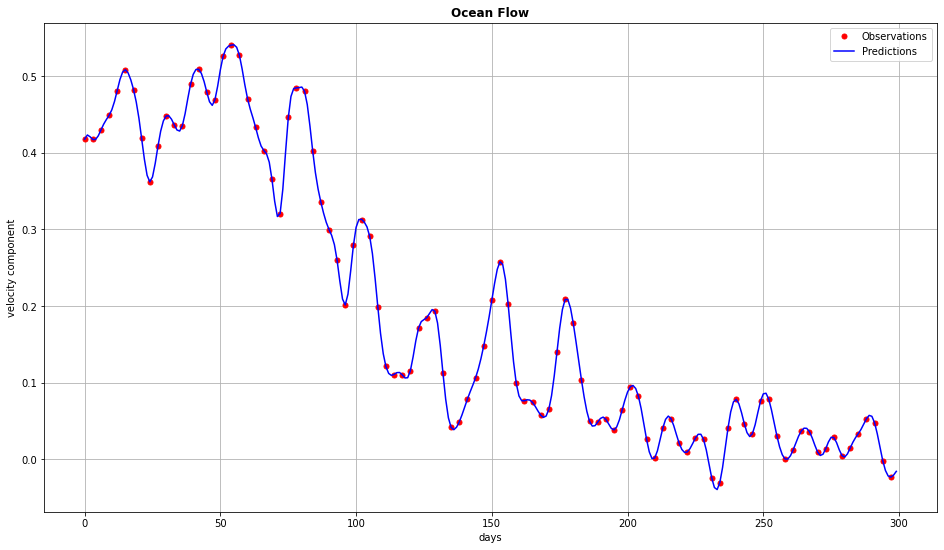


Point: (120, 440) - U component


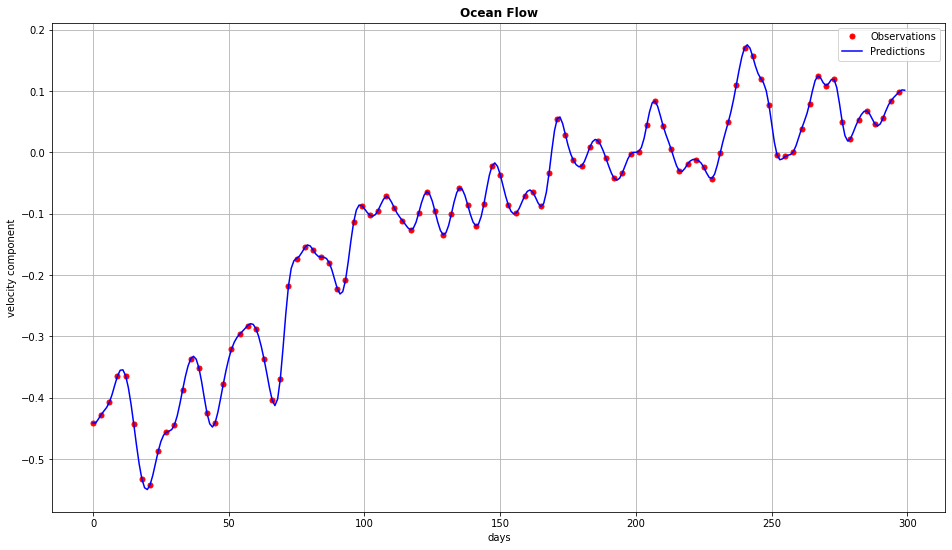


Point: (120, 440) - V component


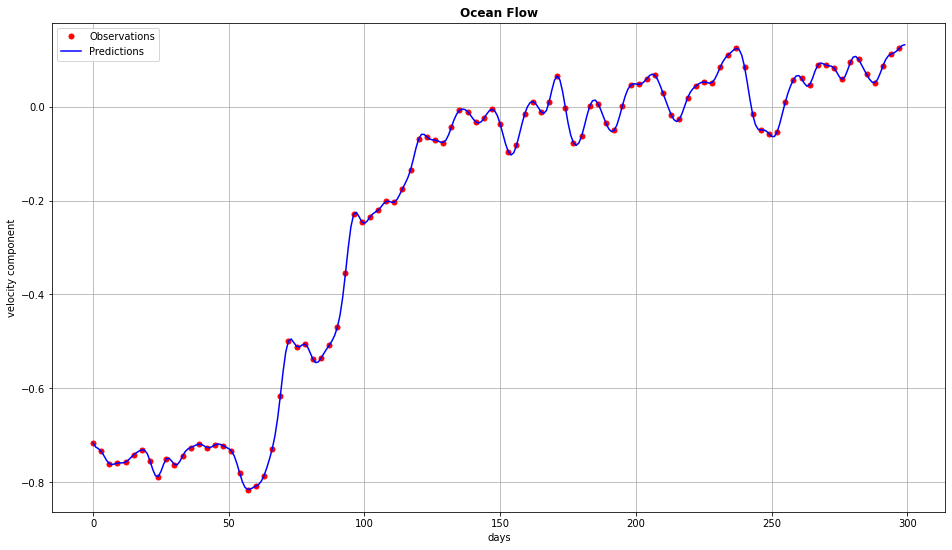


Point: (480, 120) - U component


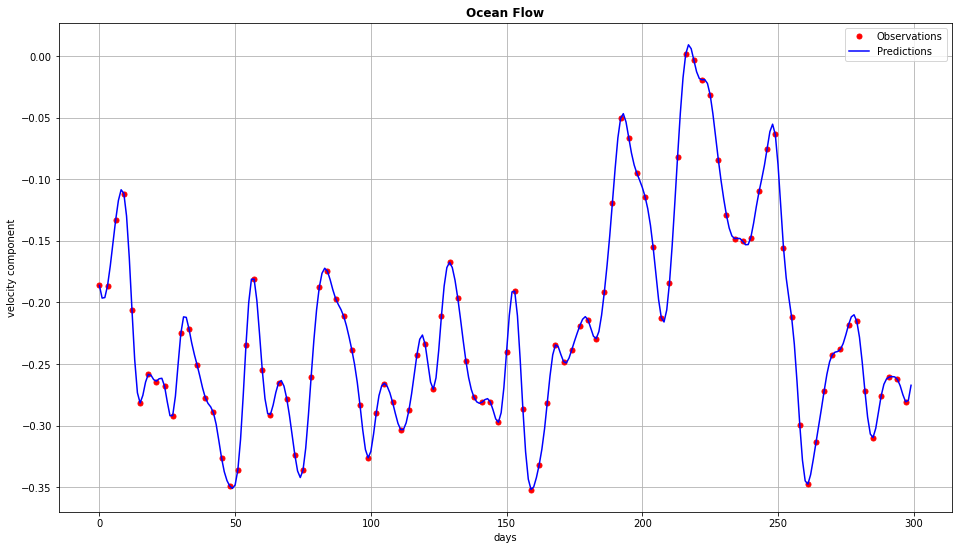


Point: (480, 120) - V component


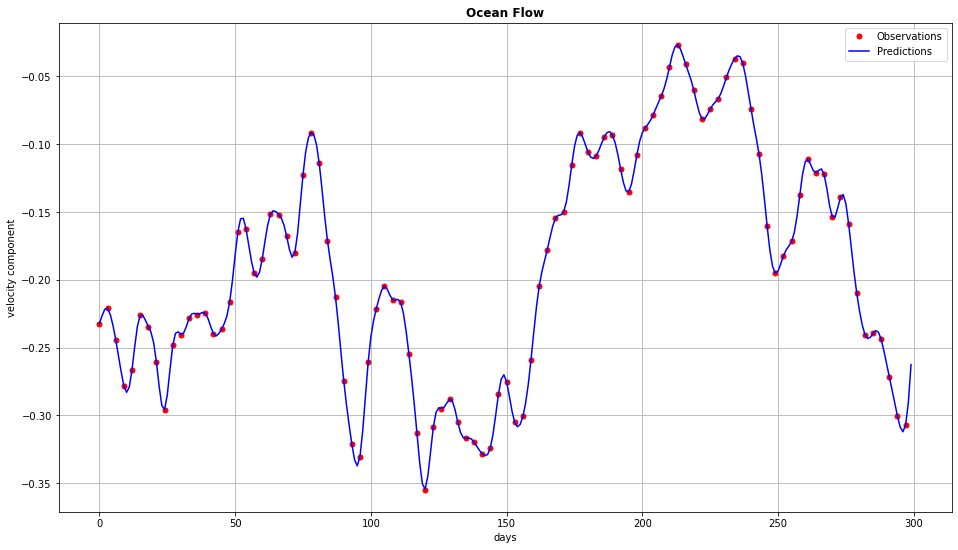


Point: (150, 210) - U component


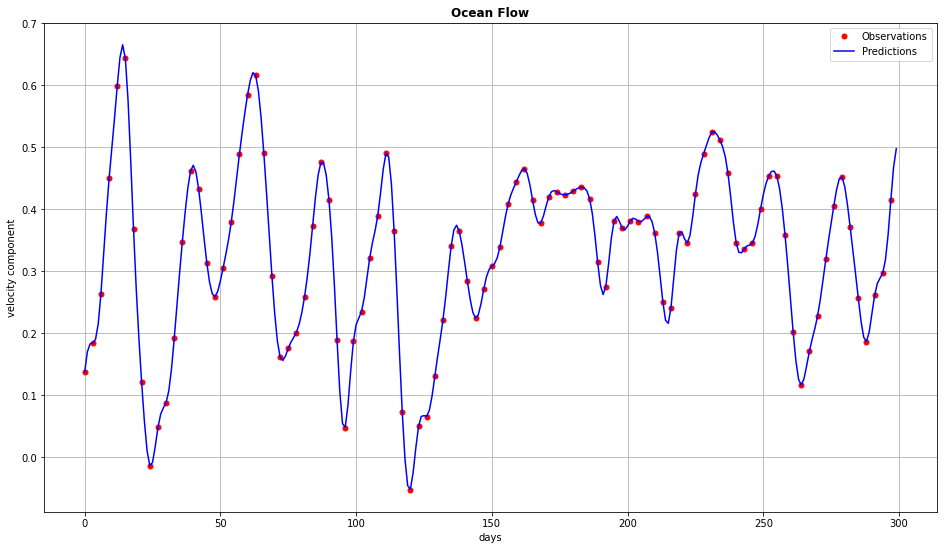


Point: (150, 210) - V component


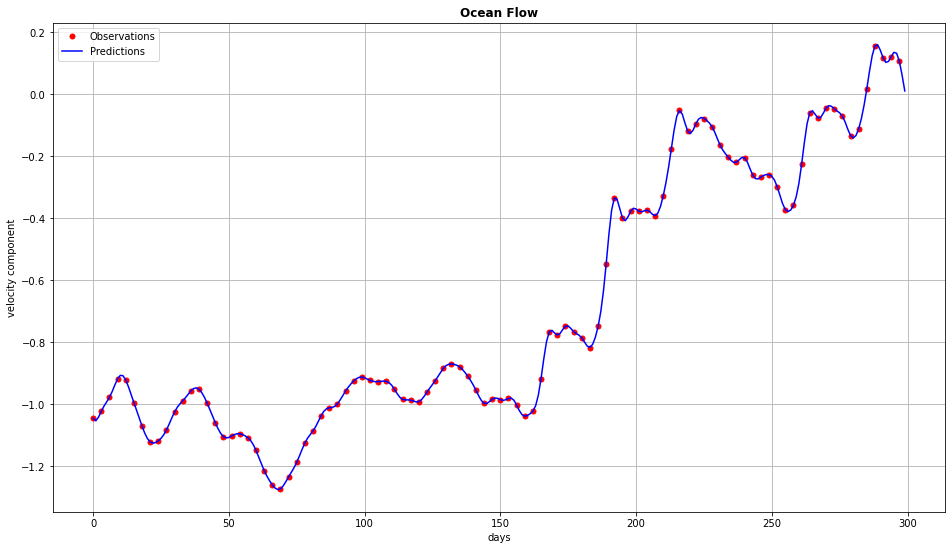

In [ ]:
# visual sanity check
# 
for x, y in coords:
  
  # plot stored U predictions
  print(f"\nPoint: ({x}, {y}) - U component")
  u_true = data[:,x,y,0] 
  u_pred = all_us[:,x,y] 
  plot_model(X_100, u_true, X_300, u_pred)

  # plot stored V predictions
  print(f"\nPoint: ({x}, {y}) - V component")
  v_true = data[:,x,y,1]
  v_pred = all_vs[:,x,y]
  plot_model(X_100, v_true, X_300, v_pred)

**that's all folks ;-)**